In [1]:
#|default_exp dataset

In [2]:
#| export
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from datasets import  load_from_disk

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pdb import set_trace
import seaborn as sns
class CFG:
    CACHE_PATH = Path('../data/cache')

In [4]:
fns = list((CFG.CACHE_PATH/'batch_3').glob('*.pth'))

In [5]:
# | export
# function that loads the data from the pth file and return the data and the label as pd.DataFrame
def load_data(
    fn: Path,
    columns_event: str = ["time", "charge", "auxiliary", "x", "y", "z"],
    columns_label: str = ["azimuth", "zenith"],
    keep_auxiliary_event: bool = False,
):
    data = torch.load(fn)
    event = pd.DataFrame.from_records(data["event"])[columns_event]
    if keep_auxiliary_event:
        event = event.query("auxiliary == True")
    label = pd.DataFrame.from_records(data["target"])[columns_label]
    return event.astype(np.float32), label


class IceCubeCasheDatasetV0(Dataset):
    def __init__(self, fns, max_events=100):
        self.fns = fns
        self.max_events = max_events

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


class IceCubeCasheDatasetV1(Dataset):
    """_summary_

    Args:
        Dataset (_type_): Same as IceCubeCasheDatasetV0 but with the option to keep the auxiliary events
    """

    def __init__(self, fns, max_events=100, keep_auxiliary_event: bool = True):
        self.fns = fns
        self.max_events = max_events
        self.keep_auxiliary_event = keep_auxiliary_event

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn, keep_auxiliary_event=self.keep_auxiliary_event)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


# collate_fn that pads the event and mask to the max length in the batch using pythorch pad_sequence
class HuggingFaceDatasetV0(Dataset):
    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = event.values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


# function to normalize input between 1 and 0
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


class HuggingFaceDatasetV1(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        # feature engineering
        event["w1"] = event["charge"] * event["time"]
        event["w0"] = event["charge"] - event["w1"]

        event["wx0"] = event.x * event.w0
        event["wy0"] = event.y * event.w0
        event["wz0"] = event.z * event.w0
        event["wx1"] = event.x * event.w1
        event["wy1"] = event.y * event.w1
        event["wz1"] = event.z * event.w1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "w1",
                "w0",
                "wx0",
                "wy0",
                "wz0",
                "wx1",
                "wy1",
                "wz1",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV2(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV3(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch

class HuggingFaceDatasetV4(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=160):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


def event_filtering_v1(batch, max_pulse_count=128, t_valid_length=6199.700247193777):
    col = batch.columns
    t_peak = batch["time"][batch["charge"].argmax()]
    t_valid_min = t_peak - t_valid_length
    t_valid_max = t_peak + t_valid_length
    t_valid = (batch["time"] > t_valid_min) * (batch["time"] < t_valid_max)
    batch["rank"] = 2 * (1 - batch["auxiliary"]) + (t_valid)
    batch = batch.sort_values(by=["rank", "charge"])
    # pick-up from backward
    batch = batch[-max_pulse_count:]
        # resort by time
    batch = batch.sort_values(by="time")
    return batch[col]
        

class HuggingFaceDatasetV5(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        event["time"] /= event["time"].max()
        
        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


In [6]:
#ds = IceCubeCasheDatasetV1(fns)
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn)
# for x in dl:
#     break

In [7]:
ds = HuggingFaceDatasetV5(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))

/usr/local/lib/python3.8/dist-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [8]:
ds[789]['event'][:, 0]

tensor([0.3554, 0.3596, 0.3827, 0.4171, 0.4366, 0.5223, 0.5235, 0.5326, 0.5472,
        0.5494, 0.5567, 0.5785, 0.5812, 0.5830, 0.5843, 0.5919, 0.5936, 0.5939,
        0.5942, 0.5969, 0.5972, 0.5995, 0.6010, 0.6010, 0.6011, 0.6016, 0.6033,
        0.6047, 0.6051, 0.6061, 0.6065, 0.6070, 0.6071, 0.6074, 0.6084, 0.6085,
        0.6088, 0.6101, 0.6105, 0.6113, 0.6113, 0.6122, 0.6124, 0.6130, 0.6135,
        0.6143, 0.6156, 0.6159, 0.6164, 0.6187, 0.6191, 0.6193, 0.6205, 0.6258,
        0.6279, 0.6287, 0.6291, 0.6311, 0.6314, 0.6327, 0.6339, 0.6371, 0.6377,
        0.6384, 0.6407, 0.6413, 0.6421, 0.6442, 0.6444, 0.6473, 0.6504, 0.6534,
        0.6565, 0.6571, 0.6572, 0.6592, 0.6601, 0.6604, 0.6649, 0.6662, 0.6716,
        0.6723, 0.6765, 0.6797, 0.6931, 0.6969, 0.7000, 0.7086, 0.7115, 0.7182,
        0.7214, 0.7264, 0.7366, 0.7449, 0.7789, 0.8100, 0.8231, 0.8319, 0.8342,
        0.8533, 0.8642, 0.8775, 0.8808, 0.8850, 0.8864, 0.9248, 0.9430, 0.9515,
        0.9614, 0.9753, 0.9764, 1.0000])

In [9]:
ds

In [10]:
# | export


# pytorch function that takes [n, x, y, z] tensor and calculates the distance between each point and returns [n x n] matrix using torch.cdist
def get_distance_matrix(xyz):
    return torch.cdist(xyz, xyz)


def get_distance_matrix_for_indices(dm, indices):
    return dm[indices][:, indices]


def get_distance_matrix_from_csv(
    path_to_geom="/opt/slh/icecube/data/sensor_geometry.csv",
):
    geom = pd.read_csv(path_to_geom)[["x", "y", "z"]]
    geom = torch.tensor(geom.values, dtype=torch.float32)
    geom = get_distance_matrix(geom)
    # nromalize goematry matrix
    geom = geom / geom.max()
    return geom


class HuggingFaceDatasetGraphV0(Dataset):
    def __init__(self, ds, min_adj_distance=0.015, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        event["charge"] = np.log10(event["charge"])

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetGraphV1(Dataset):
    def __init__(self, ds, min_adj_distance=0.05, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        # in this way the time start at 0 and end at 1
        event["time"] = (event['time'] - 1.0e04) / 3.0e4

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event['x'] /=500
        event['y'] /=500
        event['z'] /=500

        event["charge"] = np.log10(event["charge"])/3.0

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch




/usr/local/lib/python3.8/dist-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


<AxesSubplot: >

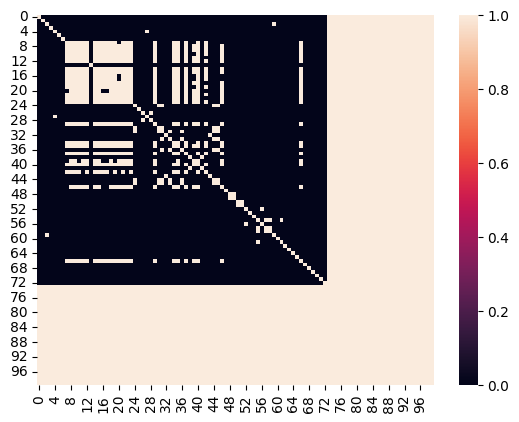

In [11]:
ds = HuggingFaceDatasetGraphV1(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))
sns.heatmap(ds[np.random.randint(0, len(ds))]['adjecent_matrix'].numpy())
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn_graphv0)
#for x in dl:
#     break

<AxesSubplot: >

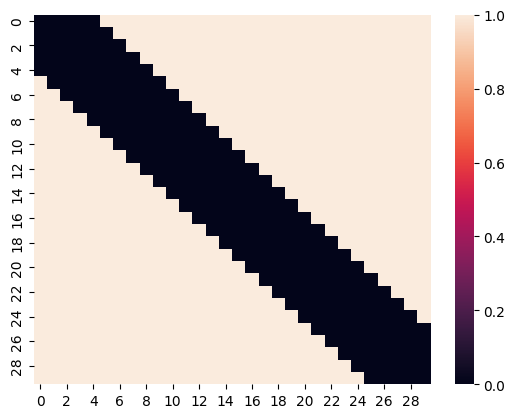

In [12]:
sns.heatmap((get_distance_matrix_from_csv() > 0.05)[200:230,200:230])

In [13]:
#| export
def good_luck():
    return True

In [14]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [15]:
# class IceCubeKaggle():
#     """`Detector` class for Kaggle Competition."""

#     # Implementing abstract class attribute

#     def _forward(self, data: Data) -> Data:
#         """Ingest data, build graph, and preprocess features.
#         Args:
#             data: Input graph data.
#         Returns:
#             Connected and preprocessed graph data.
#         """
#         # Check(s)
#         self._validate_features(data)

#         # Preprocessing
#         data.x[:, 0] /= 500.0  # x
#         data.x[:, 1] /= 500.0  # y
#         data.x[:, 2] /= 500.0  # z
#         data.x[:, 3] = (data.x[:, 3] - 1.0e04) / 3.0e4  # time
#         data.x[:, 4] = torch.log10(data.x[:, 4]) / 3.0  # charge

#         return data

# class Direction(Label):
#     """Class for producing particle direction/pointing label."""

#     def __init__(
#         self, azimuth_key: str = "azimuth", zenith_key: str = "zenith"
#     ):
#         """Construct `Direction`."""
#         self._azimuth_key = azimuth_key
#         self._zenith_key = zenith_key

#     def __call__(self, graph: Data) -> torch.tensor:
#         """Compute label for `graph`."""
#         x = torch.cos(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         y = torch.sin(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         z = torch.cos(graph[self._zenith_key]).reshape(-1, 1)
#         return torch.cat((x, y, z), dim=1)